<a href="https://colab.research.google.com/github/thomson008/pdiot-cw3/blob/main/Data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import re
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from scipy import stats
import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from google.colab import drive
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from scipy import signal
pd.options.mode.chained_assignment = None
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/pdiot-cw3/2020'

file_list = []
sensor_position = 'Chest_Right'

for root, dirs, files in os.walk(path):
    for file in files:
        if ('csv' in file and sensor_position in file and (file[0] == 's' or file[0] == 'S')):
            file_list.append(os.path.join(root, file))
            
dataframes = []

def filter(dataframe, cutoff=0.1):
    b, a = signal.butter(5, cutoff, btype='lowpass') #low pass filter

    x_low = signal.filtfilt(b, a, dataframe.accel_x)
    y_low = signal.filtfilt(b, a, dataframe.accel_y)
    z_low = signal.filtfilt(b, a, dataframe.accel_z)

    dataframe.loc[:, 'accel_x'] = x_low
    dataframe.loc[:, 'accel_y'] = y_low
    dataframe.loc[:, 'accel_z'] = z_low

for csv_file in file_list:
    with open(csv_file) as f:
        info = [next(f).rstrip().split(': ')[1] for x in range(5)]
        user_id = info[4]
        activity = info[2]

    file_data = pd.read_csv(csv_file, header=5)

    if (file_data.size):
        file_data.drop(file_data.tail(25).index, inplace=True)
        file_data.drop(file_data.head(80).index, inplace=True)
        file_data.insert(0, 'user_id', user_id)
        file_data.insert(1, 'activity', activity)
        # filter(file_data, 0.3)
        dataframes.append(file_data)


sensor_data = pd.concat(dataframes, ignore_index=True)
sensor_data.drop(sensor_data[(sensor_data.activity == 'Sitting or standing') | (sensor_data.activity == 'Movement')].index , inplace=True)

In [ ]:
scale_columns = ['accel_x', 'accel_y', 'accel_z']

def split_data(leave_subject):
    df_train, df_test = sensor_data, sensor_data.loc[sensor_data.user_id == leave_subject]
    return df_train, df_test

In [ ]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)
    
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

def create_whole_dataset(time_steps, step, subject):
    df_train, df_test = split_data(subject)

    X_train, y_train = create_dataset(
        df_train[scale_columns],
        df_train.activity,
        time_steps,
        step
    )

    X_test, y_test = create_dataset(
        df_test[scale_columns],
        df_test.activity,
        time_steps,
        step
    )

    global enc 
    enc = enc.fit(y_train)

    y_train = enc.transform(y_train)
    y_test = enc.transform(y_test)

    return X_train, y_train, X_test, y_test

verbose, epochs, batch_size = 1, 20, 32

def create_model(trainX, trainy, testX, testy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    return model

def load_dataset(time_steps, step, subject):
    # load all train
    trainX, trainy, testX, testy = create_whole_dataset(time_steps, step, subject)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

def evaluate_model(trainX, trainy, testX, testy):
    # create model
    model = create_model(trainX, trainy, testX, testy)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [ ]:
TIME_STEPS = 50
STEP = 10

trainX, trainy, testX, testy = load_dataset(TIME_STEPS, STEP, 's1758009')
model = create_model(trainX, trainy, testX, testy)
predy = model.predict(testX)

(16548, 50, 3) (16548, 13) (394, 50, 3) (394, 13)
Epoch 1/20
518/518 [==============================] - 5s 10ms/step - loss: 0.9713 - accuracy: 0.6537
Epoch 2/20
518/518 [==============================] - 5s 10ms/step - loss: 0.6178 - accuracy: 0.7569
Epoch 3/20
518/518 [==============================] - 5s 10ms/step - loss: 0.5161 - accuracy: 0.7954
Epoch 4/20
518/518 [==============================] - 5s 10ms/step - loss: 0.4491 - accuracy: 0.8259
Epoch 5/20
518/518 [==============================] - 5s 10ms/step - loss: 0.4013 - accuracy: 0.8434
Epoch 6/20
518/518 [==============================] - 5s 10ms/step - loss: 0.3655 - accuracy: 0.8606
Epoch 7/20
518/518 [==============================] - 5s 10ms/step - loss: 0.3357 - accuracy: 0.8702
Epoch 8/20
518/518 [==============================] - 5s 10ms/step - loss: 0.3136 - accuracy: 0.8791
Epoch 9/20
518/518 [==============================] - 5s 10ms/step - loss: 0.2887 - accuracy: 0.8890
Epoch 10/20
518/518 [====================

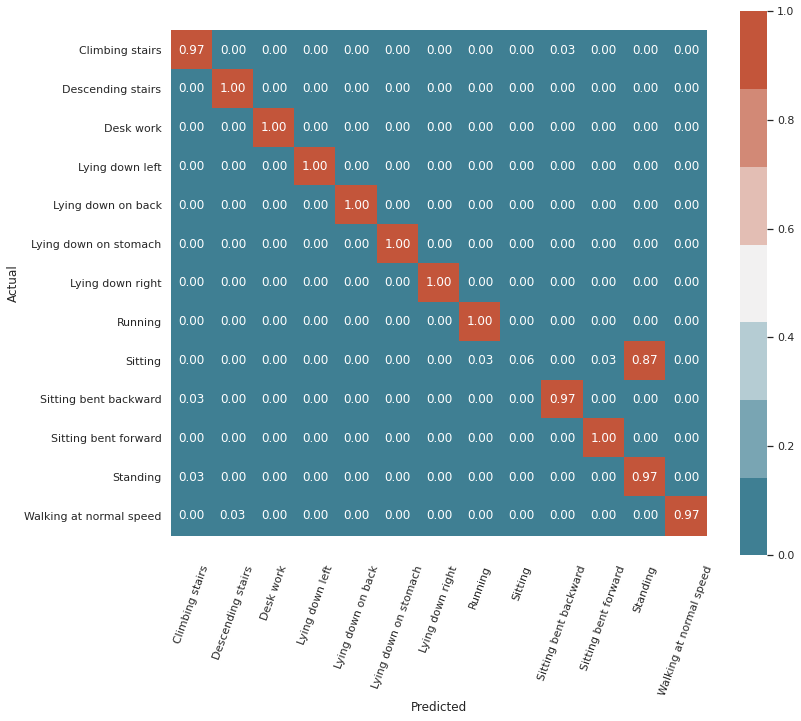

In [ ]:
def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(12, 10)) 
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt=".2f", 
        cmap=sns.diverging_palette(220, 20, n=7),
        ax=ax
    )

    plt.xticks(rotation=70)
    plt.yticks(rotation=90)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names, rotation=0)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1)

rcParams['figure.figsize'] = 22, 10

plot_cm(
    enc.inverse_transform(testy),
    enc.inverse_transform(predy),
    enc.categories_[0]
) 

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model_movement.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmperow3wmt/assets


INFO:tensorflow:Assets written to: /tmp/tmperow3wmt/assets


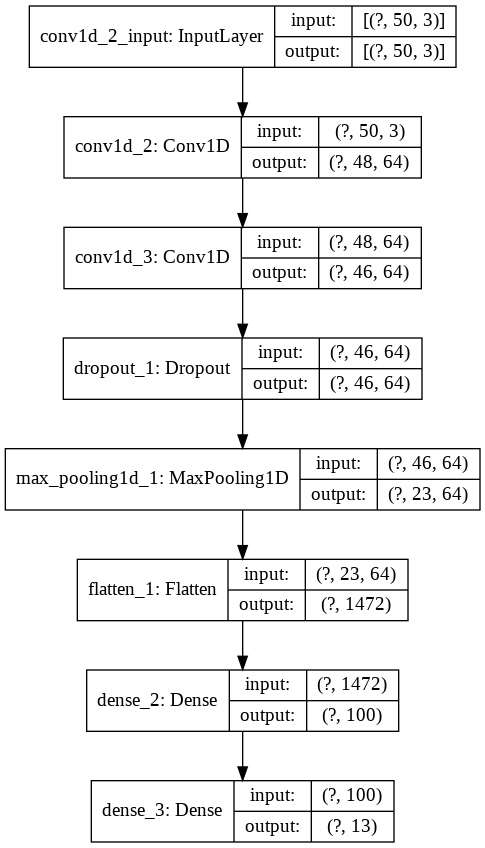

In [ ]:
plot_model(model, show_shapes=True, to_file='model.png')

In [ ]:
model.output_shape

(None, 13)